In [7]:
# Example of taking the output of our tally form to bootstrap a model card
import sys
import json
from IPython import display

# parent directory to work with dev
sys.path.append("..")
import model_card_toolkit as mctlib
from model_card_toolkit import model_card_pb2, ModelCard
from model_card_toolkit.utils.tally_form import tally_form_to_mc

## Prep test dataset

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score
import pandas as pd
import category_encoders as ce

from ModelTests.utils import plot_to_str
from ModelTests.FEAT import SubgroupDifference
from ModelTests.FEAT.SubgroupMetricThreshold import SubgroupMetricThreshold

In [45]:
# Credit dataset
# df = pd.read_csv("../data/credit_reject.csv")
# x = df.drop("reject", axis=1)
# y = df["reject"]

# # Credit Card Fraud Dataset
df = pd.read_csv("../data/fraud.csv")
x = df.drop("is_fraud", axis=1)
y = df["is_fraud"]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.8, random_state=32
)
estimator = RandomForestClassifier(n_estimators=10, max_features="sqrt")
# estimator = LogisticRegression()

# Apply one hot encoding to categorical columns (auto-detect object columns)
ens = ce.OneHotEncoder(use_cat_names=True)
x_train = ens.fit_transform(x_train)
x_test = ens.transform(x_test)

estimator.fit(x_train, y_train)

output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]
precision = round(precision_score(y_test, y_pred),3)
recall = round(recall_score(y_test, y_pred), 3)
#print(confusion_matrix(y_test, y_pred))

output = ens.inverse_transform(output)
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


df_importance = pd.DataFrame(
    {"features": x_test.columns, "value": estimator.feature_importances_}
)
#df_importance = df_importance.sort_values(df_importance.columns[1], ascending=False)
train = ens.inverse_transform(x_train)
test = ens.inverse_transform(x_test)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


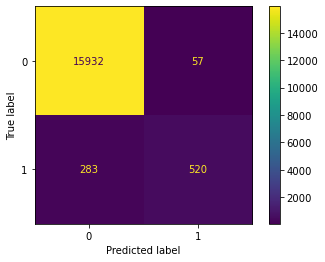

In [46]:
plot_confusion_matrix(estimator, x_test, y_test)
confusion_matrix = plot_to_str()

## Run some FEAT Tests on it

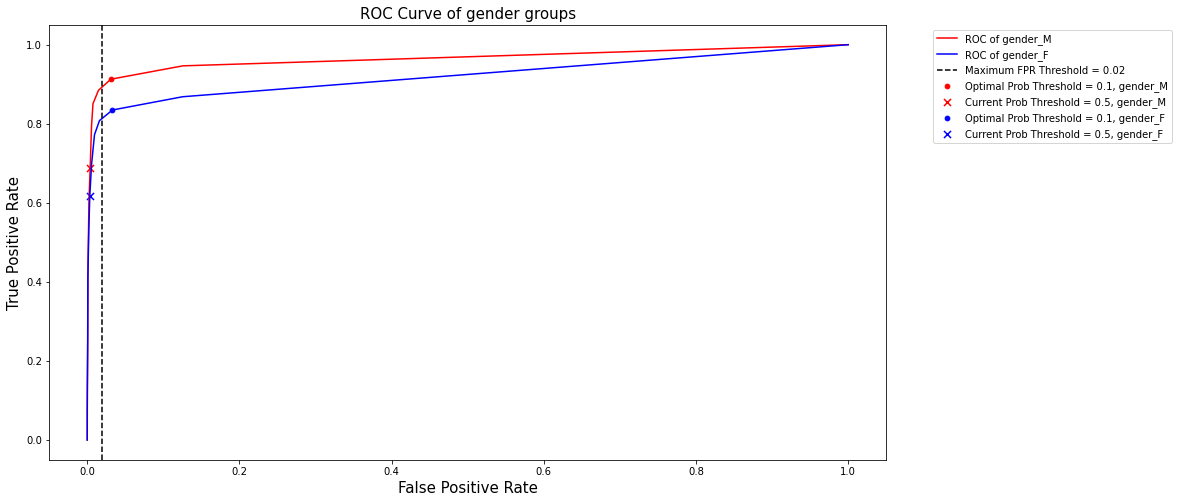

In [47]:
smt_test = SubgroupMetricThreshold(
    #test_name="subgroup metric threshold",
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.02,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

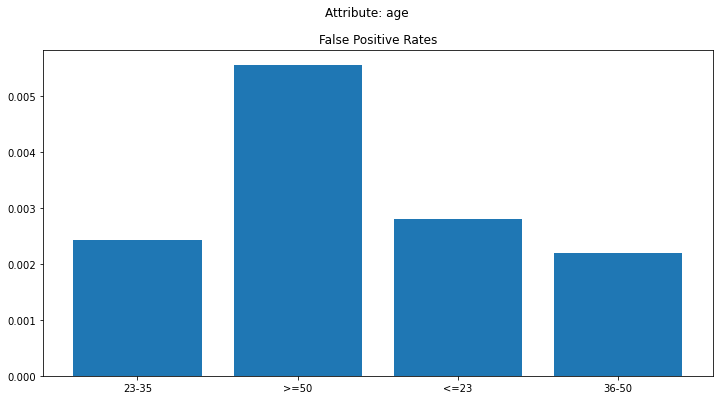

In [48]:
# SubgroupDifference Test
sgd_test = SubgroupDifference(
    #test_name='subgroup diff',
    #test_desc='my first subgroup difference test',
    attr='age',
    metric='fpr',
    method='diff',
    threshold=0.2,
)
sgd_test.run(output)
sgd_test.plot()

## Convert test objects to a model-card-compatible format

In [49]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_sgd_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_sgd_test.read_model_test(sgd_test)

In [50]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response.json")

# Saving pb
with open('./temp.proto', "wb") as f:
    f.write(pb)
    
# Loading saved pb
# Alternative to load from file:
# with open('./temp.proto', "rb") as f:
#     model_card_proto.ParseFromString(f.read())

model_card_proto = model_card_pb2.ModelCard()    
model_card_proto.ParseFromString(pb);

# Copy to new model card
mc = mctlib.ModelCard()
mc.copy_from_proto(model_card_proto);

In [51]:
# Here's how the bootstrap model card looks like in html
# You can continue editing on this card by documenting other analysis and artifacts

mct = mctlib.ModelCardToolkit(output_dir = "model_card_output/")
mct.scaffold_assets()



#mc.quantitative_analysis.performance_metrics.append(mctlib.PerformanceMetric())
mc.quantitative_analysis.performance_metrics[0].type = "Recall"
mc.quantitative_analysis.performance_metrics[0].value = str(recall)
mc.quantitative_analysis.performance_metrics[0].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[0].graphics.description = (
  'Confusion matrix')
mc.quantitative_analysis.performance_metrics[0].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix)
]


mc.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type='Model metrics of subgroups should be within a reasonable threshold', tests=[mc_smt_test,]),
    mctlib.FairnessReport(type='Model metrics across subgroups should be similar', tests=[mc_sgd_test,]),
]


mct.update_model_card(mc)

html = mct.export_format(output_file="model_card_from_tally.html")

display.display(display.HTML(html))